In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import glob
import re
import random

In [2]:
def softmax(x, c=1):
    x = np.array(x)
    x = x - max(x)
    return np.exp(x*c)/np.sum(np.exp(x*c))

# Inputs

In [3]:
I_filenames = glob.glob("data/3x3/*.png")
I_dict = {}

for i in I_filenames:
    I = cv2.imread(i)
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I = I/255
    
    I_id = re.sub(r".*_(.*)\.png", r"\1", i)
    
    I_dict.update({I_id: I})

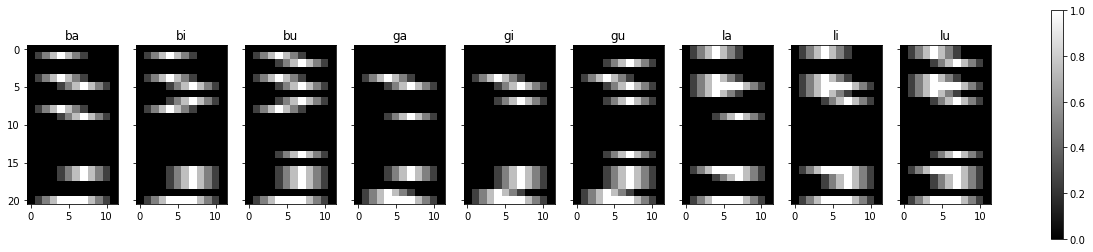

In [4]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = list(I_dict.values())[0].shape
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

for k, ax in zip(I_dict.keys(), axes.flatten()):
    im = ax.imshow(I_dict[k], cmap="gray")
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Parameters

In [5]:
np.random.seed(1)

epoch_n = 1000
epoch_max = max(range(epoch_n))

vec_len = len(I_dict)
r1 = np.zeros(32)
r2 = np.zeros(vec_len)

I_size = I.shape[0]
r1_size = r1.shape[0]
r2_size = r2.shape[0]

U1 = np.random.normal(loc=0, scale=0.1, size=(I_size, r1_size))
U2 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r2_size))
V1 = np.random.normal(loc=0, scale=0.1, size=(r1_size, r1_size))
V2 = np.random.normal(loc=0, scale=0.1, size=(r2_size, r2_size))

s10 = 100
s11 = 100
s21 = 100
s22 = 100
s32 = 100

Nr1 = 1
Nr2 = 0.1
Nu1 = 10
Nu2 = 10
Nv1 = 10
Nv2 = 10

# Before Training

In [6]:
output_test = {"input": [], "label": [], "target_vec": [], "index": [], "node": [],
               "r1_hat": [], "U1_hat": [], "V1_hat": [], "r2_hat": [], "U2_hat": [], "V2_hat": [],
               "r1_bar": [], "r2_bar": []}

U1_hat = U1.copy()
V1_hat = V1.copy()
U2_hat = U2.copy()
V2_hat = V2.copy()

for k in I_dict.keys():
    I = I_dict[k]
    k_idx = list(I_dict.keys()).index(k)
    L = np.eye(len(I_dict))[k_idx]
    
    r1_hat = r1.copy()
    r2_hat = r2.copy()

    r1_bar = r1.copy()
    r2_bar = r2.copy()
    
    for idx in np.arange(I.shape[1]):
        output_test["r1_bar"].append(r1_bar.copy())
        output_test["r2_bar"].append(r1_bar.copy())
        
        node = np.arange(vec_len)

        U1_bar = U1_hat.copy()
        V1_bar = V1_hat.copy()
        U2_bar = U2_hat.copy()
        V2_bar = V2_hat.copy()

        r1_hat = r1_bar + Nr1/s10 * U1_bar.T @ (I[:, idx] - U1_bar @ r1_bar)
        r2_hat = r2_bar + Nr2/s21 * U2_bar.T @ (r1_bar - U2_bar @ r2_bar)

        r1_bar = V1_bar @ r1_hat
        r2_bar = V2_bar @ r2_hat

        output_test["input"].append(I[:, idx])
        output_test["label"].append(k)
        output_test["target_vec"].append(L)
        output_test["index"].append(idx)
        output_test["node"].append(node)
        
        output_test["r1_hat"].append(r1_hat.copy())
        output_test["U1_hat"].append(U1_hat.copy())
        output_test["V1_hat"].append(V1_hat.copy())
        output_test["r2_hat"].append(r2_hat.copy())
        output_test["U2_hat"].append(U2_hat.copy())
        output_test["V2_hat"].append(V2_hat.copy())

output_test_df = pd.DataFrame.from_dict(output_test)

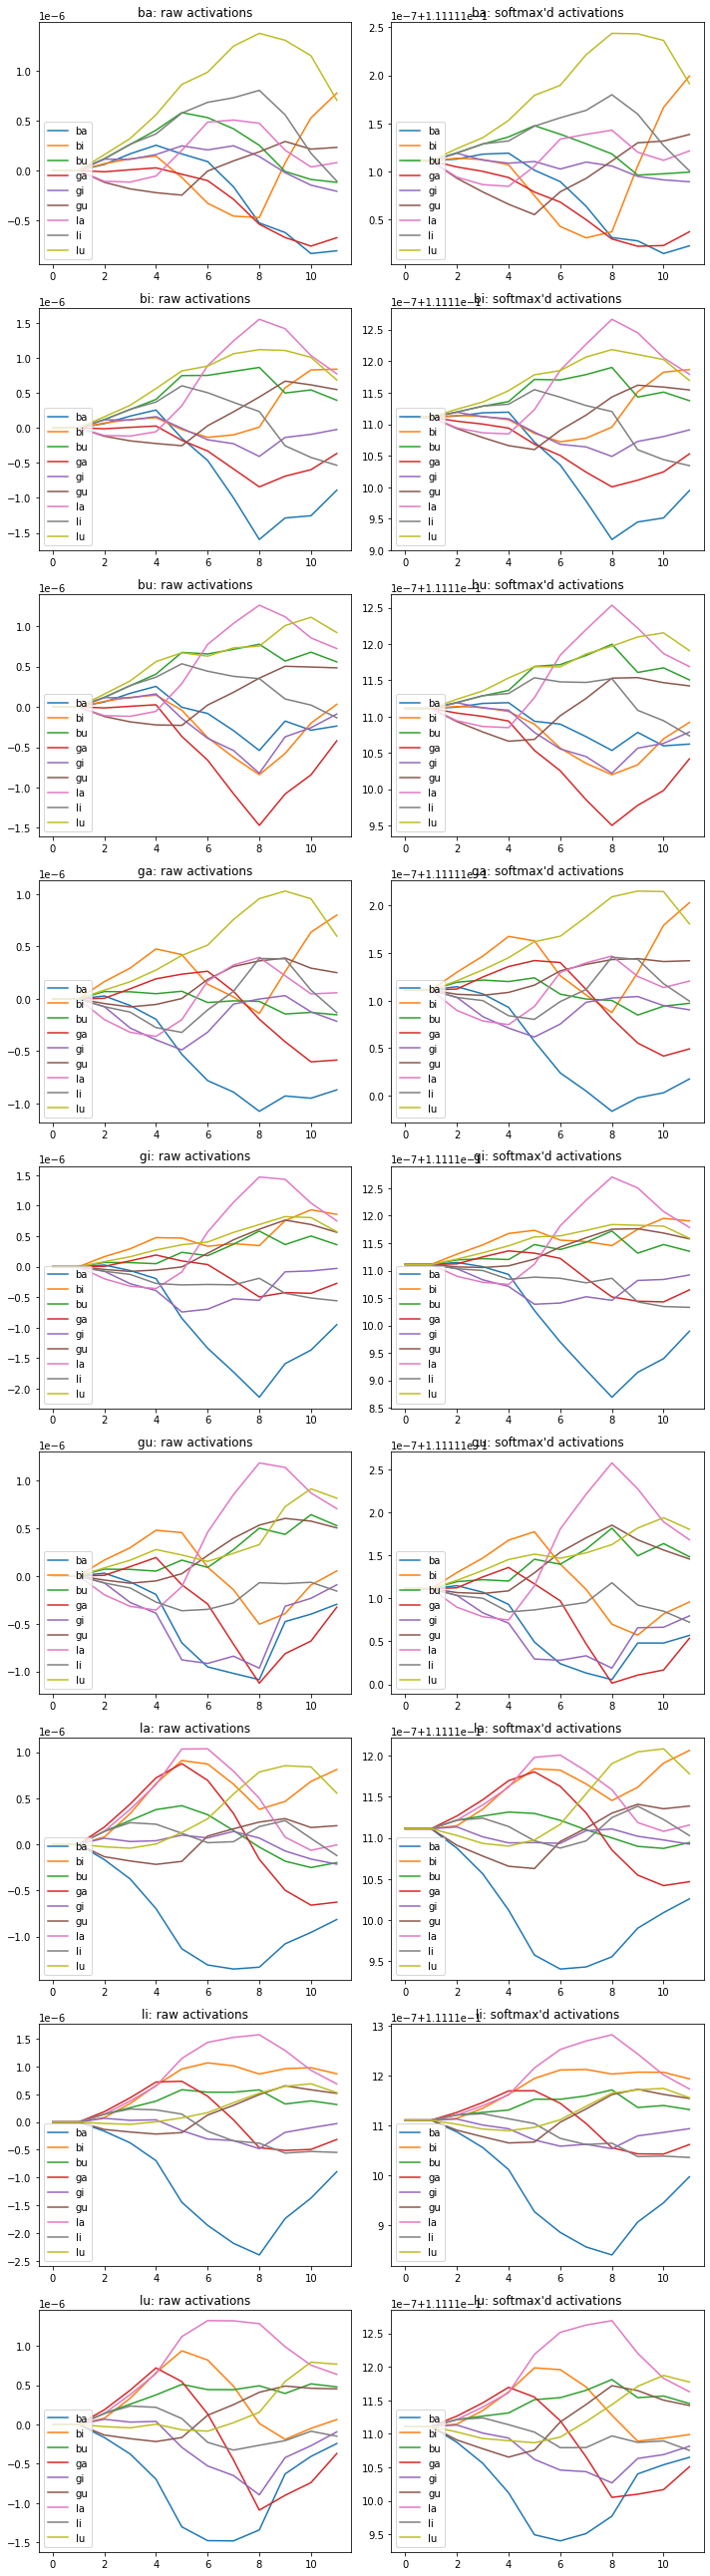

In [7]:
ncols = 2
nrows = len(I_dict)

subplot_y, subplot_x = (4, 5)

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows))

for k in I_dict.keys():
    k_idx = list(I_dict.keys()).index(k)

    raw_r = output_test_df.groupby("label").get_group(k).r2_hat.apply(lambda x: pd.Series(x)).reset_index(drop=True)
    softmaxd_r = output_test_df.groupby("label").get_group(k).r2_hat.apply(lambda x: pd.Series(softmax(x))).reset_index(drop=True)

    raw_r.columns = list(I_dict.keys())
    softmaxd_r.columns = list(I_dict.keys())
    
    raw_r.plot(ax=axes[k_idx, 0], title="{}: raw activations".format(k)).legend(loc="lower left");
    softmaxd_r.plot(ax=axes[k_idx, 1], title="{}: softmax'd activations".format(k)).legend(loc="lower left");
    
plt.tight_layout();

## Training

In [8]:
output_train = {"epoch": [], "input": [], "label": [], "target_vec": [], "index": [], "node": [],
               "r1_hat": [], "U1_hat": [], "V1_hat": [], "r2_hat": [], "U2_hat": [], "V2_hat": [],
               "r1_bar": [], "r2_bar": []}

for epoch in np.arange(epoch_n):
    train_order = random.sample(list(I_dict.keys()), len(list(I_dict.keys())))
    
    for k in I_dict.keys():
        I = I_dict[k]
        k_idx = list(I_dict.keys()).index(k)
        L = np.eye(len(I_dict))[k_idx]
        
        r1_hat = r1.copy()
        r2_hat = r2.copy()

        r1_bar = r1.copy()
        r2_bar = r2.copy()

        for idx in np.arange(I.shape[1]):
            output_train["r1_bar"].append(r1_bar.copy())
            output_train["r2_bar"].append(r2_bar.copy())
            
            node = np.arange(vec_len)

            r1_hat_old = r1_hat.copy()
            U1_bar = U1_hat.copy()
            V1_bar = V1_hat.copy()
            
            r2_hat_old = r2_hat.copy()
            U2_bar = U2_hat.copy()
            V2_bar = V2_hat.copy()

            r1_hat = r1_bar + Nr1/s10 * U1_bar.T @ (I[:, idx] - U1_bar @ r1_bar) - Nr1/s21 * (r1_bar - U2_bar @ r2_bar)
            r2_hat = r2_bar + Nr2/s21 * U2_bar.T @ (r1_bar - U2_bar @ r2_bar) - Nr2/s32 * (softmax(r2_bar) - L)
            
            U1_hat = U1_bar + Nu1/s10 * np.outer(I[:, idx] - U1_bar @ r1_hat, r1_hat)
            U2_hat = U2_bar + Nu2/s21 * np.outer(r1_bar - U2_bar @ r2_hat, r2_hat)

            V1_hat = V1_bar + Nv1/s11 * np.outer(r1_hat - r1_bar, r1_hat_old)
            V2_hat = V2_bar + Nv2/s22 * np.outer(r2_hat - r2_bar, r2_hat_old)

            r1_bar = V1_bar @ r1_hat
            r2_bar = V2_bar @ r2_hat

            output_train["epoch"].append(epoch)
            output_train["input"].append(I[:, idx])
            output_train["label"].append(k)
            output_train["target_vec"].append(L)
            output_train["index"].append(idx)
            output_train["node"].append(node)

            output_train["r1_hat"].append(r1_hat.copy())
            output_train["U1_hat"].append(U1_hat.copy())
            output_train["V1_hat"].append(V1_hat.copy())
            output_train["r2_hat"].append(r2_hat.copy())
            output_train["U2_hat"].append(U2_hat.copy())
            output_train["V2_hat"].append(V2_hat.copy())

output_train_df = pd.DataFrame.from_dict(output_train)

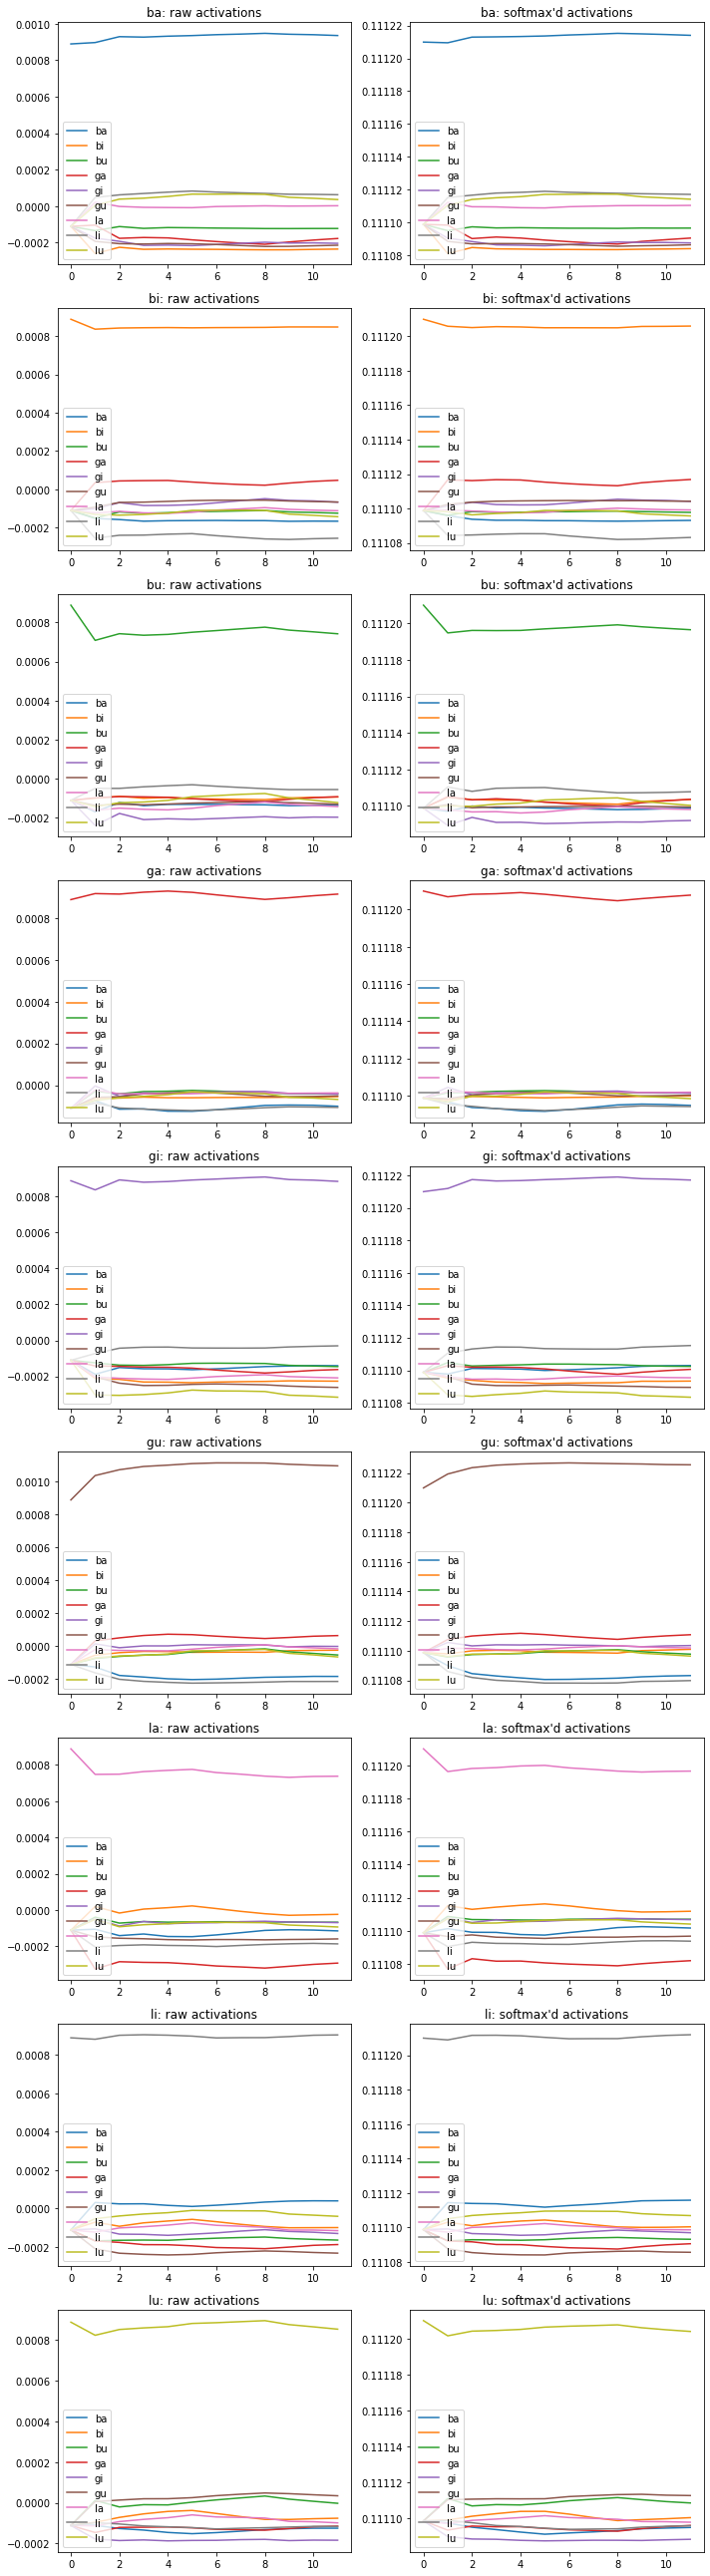

In [9]:
ncols = 2
nrows = len(I_dict)

subplot_y, subplot_x = (4, 5)

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows))

for k in I_dict.keys():
    k_idx = list(I_dict.keys()).index(k)

    raw_r = output_train_df.groupby(["epoch", "label"]).get_group((epoch_max, k)).r2_hat.apply(lambda x: pd.Series(x)).reset_index(drop=True)
    softmaxd_r = output_train_df.groupby(["epoch", "label"]).get_group((epoch_max, k)).r2_hat.apply(lambda x: pd.Series(softmax(x))).reset_index(drop=True)

    raw_r.columns = list(I_dict.keys())
    softmaxd_r.columns = list(I_dict.keys())
    
    raw_r.plot(ax=axes[k_idx, 0], title="{}: raw activations".format(k)).legend(loc="lower left");
    softmaxd_r.plot(ax=axes[k_idx, 1], title="{}: softmax'd activations".format(k)).legend(loc="lower left");
    
plt.tight_layout();

## Testing

In [10]:
output_test = {"input": [], "label": [], "target_vec": [], "index": [], "node": [],
               "r1_hat": [], "U1_hat": [], "V1_hat": [], "r2_hat": [], "U2_hat": [], "V2_hat": [],
               "r1_bar": [], "r2_bar": []}

for k in I_dict.keys():
    I = I_dict[k]
    k_idx = list(I_dict.keys()).index(k)
    L = np.eye(len(I_dict))[k_idx]
    
    r1_hat = r1.copy()
    r2_hat = r2.copy()

    r1_bar = r1.copy()
    r2_bar = r2.copy()

    for idx in np.arange(I.shape[1]):
        output_test["r1_bar"].append(r1_bar.copy())
        output_test["r2_bar"].append(r2_bar.copy())
        
        node = np.arange(vec_len)

        U1_bar = U1_hat.copy()
        V1_bar = V1_hat.copy()
        U2_bar = U2_hat.copy()
        V2_bar = V2_hat.copy()

        r1_hat = r1_bar + Nr1/s10 * U1_bar.T @ (I[:, idx] - U1_bar @ r1_bar)
        r2_hat = r2_bar + Nr2/s21 * U2_bar.T @ (r1_bar - U2_bar @ r2_bar)

        r1_bar = V1_bar @ r1_hat
        r2_bar = V2_bar @ r2_hat

        output_test["input"].append(I[:, idx])
        output_test["label"].append(k)
        output_test["target_vec"].append(L)
        output_test["index"].append(idx)
        output_test["node"].append(node)
        
        output_test["r1_hat"].append(r1_hat.copy())
        output_test["U1_hat"].append(U1_hat.copy())
        output_test["V1_hat"].append(V1_hat.copy())
        output_test["r2_hat"].append(r2_hat.copy())
        output_test["U2_hat"].append(U2_hat.copy())
        output_test["V2_hat"].append(V2_hat.copy())

output_test_df = pd.DataFrame.from_dict(output_test)

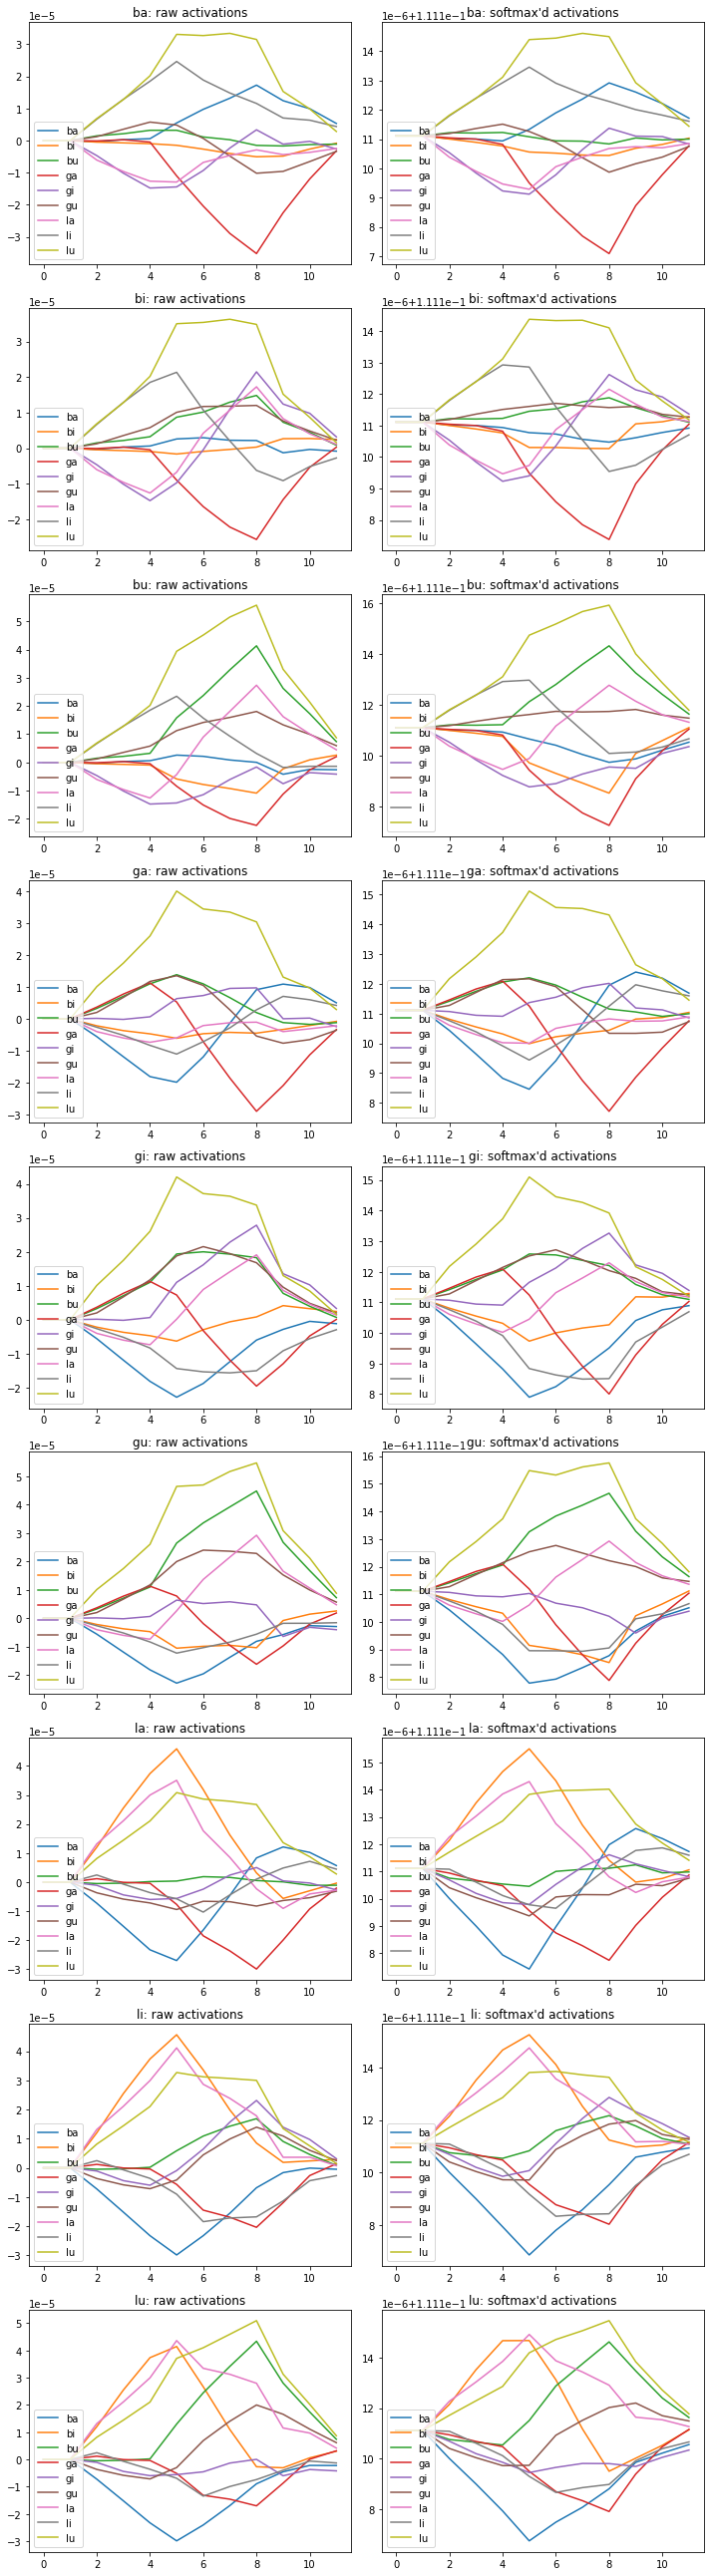

In [11]:
ncols = 2
nrows = len(I_dict)

subplot_y, subplot_x = (4, 5)

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows))

for k in I_dict.keys():
    k_idx = list(I_dict.keys()).index(k)

    raw_r = output_test_df.groupby("label").get_group(k).r2_hat.apply(lambda x: pd.Series(x)).reset_index(drop=True)
    softmaxd_r = output_test_df.groupby("label").get_group(k).r2_hat.apply(lambda x: pd.Series(softmax(x))).reset_index(drop=True)

    raw_r.columns = list(I_dict.keys())
    softmaxd_r.columns = list(I_dict.keys())
    
    raw_r.plot(ax=axes[k_idx, 0], title="{}: raw activations".format(k)).legend(loc="lower left");
    softmaxd_r.plot(ax=axes[k_idx, 1], title="{}: softmax'd activations".format(k)).legend(loc="lower left");
    
plt.tight_layout();

# Input Reconstruction

## Actual Inputs

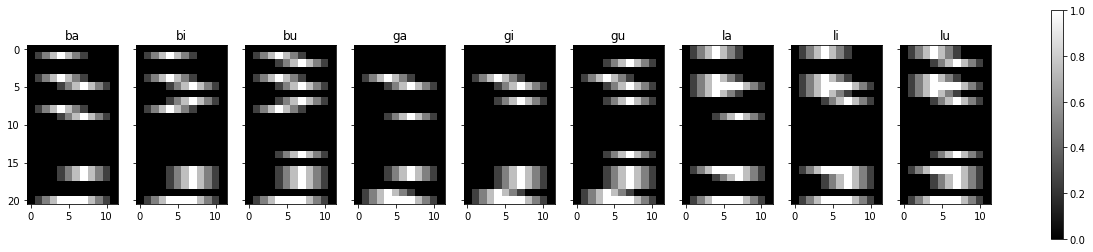

In [12]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = list(I_dict.values())[0].shape
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_test_df.apply(lambda x: pd.Series(x.input), axis=1).values.min()
vmax = output_test_df.apply(lambda x: pd.Series(x.input), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    input_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series(x.input), axis=1).values.T
    im = ax.imshow(input_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

## Reconstruction Based on r1_hat

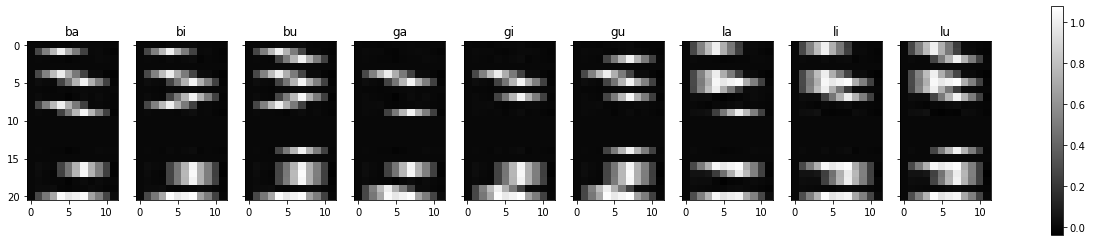

In [13]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = list(I_dict.values())[0].shape
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_test_df.apply(lambda x: pd.Series(x.U1_hat @ x.r1_hat), axis=1).values.min()
vmax = output_test_df.apply(lambda x: pd.Series(x.U1_hat @ x.r1_hat), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    r1_recon_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series(x.U1_hat @ x.r1_hat), axis=1).values.T
    im = ax.imshow(r1_recon_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

## Reconstruction Based on r1_bar

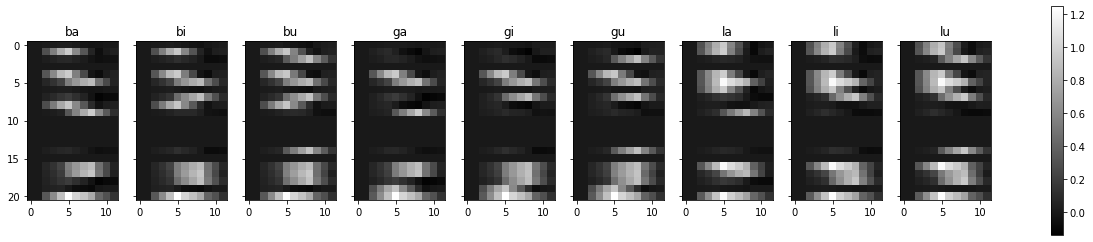

In [14]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = list(I_dict.values())[0].shape
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_test_df.apply(lambda x: pd.Series(x.U1_hat @ x.r1_bar), axis=1).values.min()
vmax = output_test_df.apply(lambda x: pd.Series(x.U1_hat @ x.r1_bar), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    r1_recon_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series(x.U1_hat @ x.r1_bar), axis=1).values.T
    im = ax.imshow(r1_recon_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

## Differences of Reconstruction of r1_bar and r1_hat

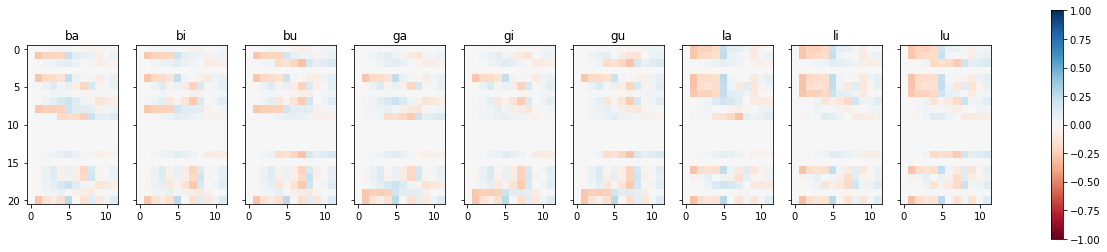

In [15]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = list(I_dict.values())[0].shape
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

# vmin = output_test_df.apply(lambda x: pd.Series((x.U1_hat @ x.r1_bar) - (x.U1_hat @ x.r1_hat)), axis=1).values.min()
# vmax = output_test_df.apply(lambda x: pd.Series((x.U1_hat @ x.r1_bar) - (x.U1_hat @ x.r1_hat)), axis=1).values.max()
vmin = -1
vmax = 1

for k, ax in zip(I_dict.keys(), axes.flatten()):
    r1_recon_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series((x.U1_hat @ x.r1_bar) - (x.U1_hat @ x.r1_hat)), axis=1).values.T
    im = ax.imshow(r1_recon_all, cmap="RdBu", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

# Target Reconstruction

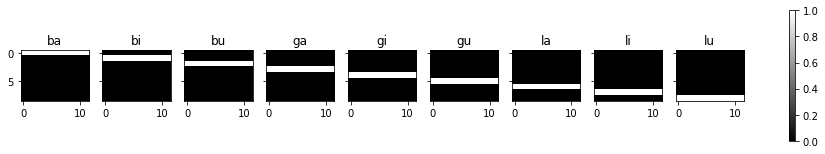

In [16]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = (12, 9)
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_test_df.apply(lambda x: pd.Series(x.target_vec), axis=1).values.min()
vmax = output_test_df.apply(lambda x: pd.Series(x.target_vec), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    L_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series(x.target_vec), axis=1).values.T
    im = ax.imshow(L_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

## Training

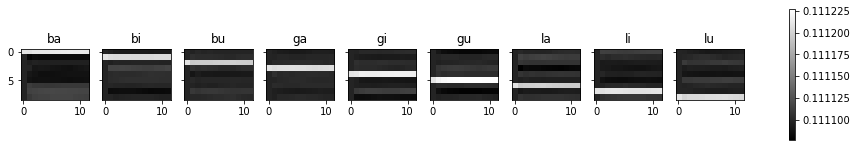

In [17]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = (12, 9)
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_train_df.groupby("epoch").get_group(epoch_max).apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.min()
vmax = output_train_df.groupby("epoch").get_group(epoch_max).apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    softmax_r2_all = output_train_df.groupby(["epoch", "label"]).get_group((epoch_max, k)).apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.T
    im = ax.imshow(softmax_r2_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());

## Testing

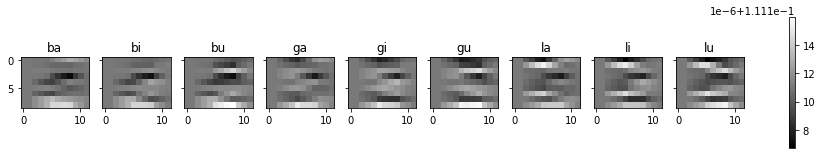

In [18]:
ncols = 9
nrows = int(np.ceil(len(I_dict)/ncols))

subplot_y, subplot_x = (12, 9)
subplot_y /= 5
subplot_x /= 5

fig, axes = plt.subplots(nrows, ncols, figsize=(subplot_x*ncols, subplot_y*nrows), sharey=True)

vmin = output_test_df.apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.min()
vmax = output_test_df.apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.max()

for k, ax in zip(I_dict.keys(), axes.flatten()):
    softmax_r2_all = output_test_df.groupby("label").get_group(k).apply(lambda x: pd.Series(softmax(x.r2_hat)), axis=1).values.T
    im = ax.imshow(softmax_r2_all, cmap="gray", vmin=vmin, vmax=vmax)
    ax.set_title(k)
    
fig.colorbar(im, ax=axes.ravel().tolist());